<a href="https://colab.research.google.com/github/CHGROSJEAN/2024_MLEES/blob/main/Projet/Projet_Charlotte_Grosjean_Pseudo_Labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Import libraries and data


Frist step, simple GMM for 2 stations : Grand-Vennes and Riand-Pré.

In [1]:
# Import
import tensorflow as tf
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
import os
from shapely.geometry import Point
from sklearn.metrics import silhouette_score
from sklearn.linear_model import SGDOneClassSVM
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score



In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


Download data sets

In [3]:
# Reading the Excel files
grandvennes = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/GrandVennes.xlsx")
riandpre = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/RiandPre.xlsx")
chandieu = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Chandieu.xlsx")
geopolis = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Geopolis.xlsx")
lexplore = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/LExplore.xlsx")
bethusy = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Bethusy.xlsx")
boisgentils = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/BoisGentils.xlsx")
elysee = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Elysee.xlsx")
pontaise = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Pontaise.xlsx")
rouvraie = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Rouvraie.xlsx")
vclb = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/VersChezLesBlancs.xlsx")




DateTime ajustment

In [4]:
# Ensuring the 'DateTime' the column is of datetime type for both datasets
grandvennes['DateTime'] = pd.to_datetime(grandvennes['DateTime'], dayfirst=True)
riandpre['DateTime'] = pd.to_datetime(riandpre['DateTime'], dayfirst=True)
chandieu['DateTime'] = pd.to_datetime(chandieu['DateTime'], dayfirst=True)
geopolis['DateTime'] = pd.to_datetime(geopolis['DateTime'], dayfirst=True)
lexplore['DateTime'] = pd.to_datetime(lexplore['DateTime'], dayfirst=True)
bethusy['DateTime'] = pd.to_datetime(bethusy['DateTime'], dayfirst=True)
boisgentils['DateTime'] = pd.to_datetime(boisgentils['DateTime'], dayfirst=True)
elysee['DateTime'] = pd.to_datetime(elysee['DateTime'], dayfirst=True)
pontaise['DateTime'] = pd.to_datetime(pontaise['DateTime'], dayfirst=True)
rouvraie['DateTime'] = pd.to_datetime(rouvraie['DateTime'], dayfirst=True)
vclb['DateTime'] = pd.to_datetime(vclb['DateTime'], dayfirst=True)



# Setting the DateTime column as the index for easier time-based operations
grandvennes.set_index('DateTime', inplace=True)
riandpre.set_index('DateTime', inplace=True)
chandieu.set_index('DateTime', inplace=True)
geopolis.set_index('DateTime', inplace=True)
lexplore.set_index('DateTime', inplace=True)
bethusy.set_index('DateTime', inplace=True)
boisgentils.set_index('DateTime', inplace=True)
elysee.set_index('DateTime', inplace=True)
pontaise.set_index('DateTime', inplace=True)
rouvraie.set_index('DateTime', inplace=True)
vclb.set_index('DateTime', inplace=True)

Aligning all station to be merged in 1 dataset

In [5]:
# Round down the DateTime to the previous minute (removes seconds, truncating)
grandvennes.index = grandvennes.index.floor('min')  # rounded to the nearest lower minute
riandpre.index = riandpre.index.floor('min')
bethusy.index = bethusy.index.floor('min')
boisgentils.index = boisgentils.index.floor('min')
chandieu.index = chandieu.index.floor('min')
elysee.index = elysee.index.floor('min')
lexplore.index = lexplore.index.floor('min')
pontaise.index = pontaise.index.floor('min')
rouvraie.index = rouvraie.index.floor('min')
vclb.index = vclb.index.floor('min')
geopolis.index = geopolis.index.floor('min')

# Resample both datasets to ensure they have data every 3 minutes (if necessary)
# Resampling to the closest 3-minute interval and filling missing values with NaN
grandvennes_resampled = grandvennes.resample('3min').mean()
riandpre_resampled = riandpre.resample('3min').mean()
bethusy_resampled = bethusy.resample('3min').mean()
boisgentils_resampled = boisgentils.resample('3min').mean()
chandieu_resampled = chandieu.resample('3min').mean()
elysee_resampled = elysee.resample('3min').mean()
lexplore_resampled = lexplore.resample('3min').mean()
pontaise_resampled = pontaise.resample('3min').mean()
rouvraie_resampled = rouvraie.resample('3min').mean()
vclb_resampled = vclb.resample('3min').mean()
geopolis_resampled = geopolis.resample('3min').mean()


# Align both datasets to the common time period (intersection of their timestamps)
start_time = max(grandvennes_resampled.index.min(), riandpre_resampled.index.min(),bethusy_resampled.index.min(),
                 boisgentils_resampled.index.min(),chandieu_resampled.index.min(),elysee_resampled.index.min(), lexplore_resampled.index.min(),
                 pontaise_resampled.index.min(),rouvraie_resampled.index.min(),vclb_resampled.index.min(),geopolis_resampled.index.min())


end_time = min(grandvennes_resampled.index.max(), riandpre_resampled.index.max(), bethusy_resampled.index.max(),
               boisgentils_resampled.index.max(),chandieu_resampled.index.max(),elysee_resampled.index.max(),lexplore_resampled.index.max(),
               pontaise_resampled.index.max(),rouvraie_resampled.index.max(),vclb_resampled.index.max(),geopolis_resampled.index.max())

grandvennes_aligned = grandvennes_resampled.loc[start_time:end_time]
riandpre_aligned = riandpre_resampled.loc[start_time:end_time]
bethusy_aligned = bethusy_resampled.loc[start_time:end_time]
boisgentils_aligned = boisgentils_resampled.loc[start_time:end_time]
chandieu_aligned = chandieu_resampled.loc[start_time:end_time]
elysee_aligned = elysee_resampled.loc[start_time:end_time]
lexplore_aligned = lexplore_resampled.loc[start_time:end_time]
pontaise_aligned = pontaise_resampled.loc[start_time:end_time]
rouvraie_aligned = rouvraie_resampled.loc[start_time:end_time]
vclb_aligned = vclb_resampled.loc[start_time:end_time]
geopolis_aligned = geopolis_resampled.loc[start_time:end_time]

# Drop rows with missing values from both datasets
grandvennes_aligned = grandvennes_aligned.dropna()
riandpre_aligned = riandpre_aligned.dropna()
bethusy_aligned = bethusy_aligned.dropna()
boisgentils_aligned = boisgentils_aligned.dropna()
chandieu_aligned = chandieu_aligned.dropna()
elysee_aligned = elysee_aligned.dropna()
lexplore_aligned = lexplore_aligned.dropna()
pontaise_aligned = pontaise_aligned.dropna()
rouvraie_aligned = rouvraie_aligned.dropna()
vclb_aligned = vclb_aligned.dropna()
geopolis_aligned = geopolis_aligned.dropna()


Merging all stations datasets in 1 dataset

In [6]:
# Merge the datasets on the 'DateTime' index
combined_data = pd.concat(
    [
        grandvennes_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Grandvennes'}),
        riandpre_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Riandpre'}),
        bethusy_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Bethusy'}),
        boisgentils_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Boisgentils'}),
        chandieu_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Chandieu'}),
        elysee_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Elysee'}),
        lexplore_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Lexplore'}),
        pontaise_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Pontaise'}),
        rouvraie_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Rouvraie'}),
        vclb_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_VCLB'}),
        geopolis_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Geopolis'})
    ],
    axis=1,
    join='inner'  # Ensures alignment on shared indices only
)

# Display the first few rows of the combined data
print("Combined Precipitation Data:")
print(combined_data.head())
print(combined_data.shape)



Combined Precipitation Data:
                     Precipitation_Grandvennes  Precipitation_Riandpre  \
DateTime                                                                 
2023-01-19 14:03:00                        0.0                     5.0   
2023-01-19 14:06:00                        0.0                     5.0   
2023-01-19 14:09:00                        0.0                     2.0   
2023-01-19 14:12:00                        0.0                     1.0   
2023-01-19 14:15:00                        0.0                     0.0   

                     Precipitation_Bethusy  Precipitation_Boisgentils  \
DateTime                                                                
2023-01-19 14:03:00                    0.0                        0.0   
2023-01-19 14:06:00                    0.0                        0.0   
2023-01-19 14:09:00                    0.0                        0.0   
2023-01-19 14:12:00                    0.0                        0.0   
2023-01-19 14:

In [7]:
X = combined_data[['Precipitation_Grandvennes', 'Precipitation_Riandpre', 'Precipitation_Bethusy', 'Precipitation_Boisgentils', 'Precipitation_Chandieu', 'Precipitation_Elysee', 'Precipitation_Lexplore', 'Precipitation_Pontaise', 'Precipitation_Rouvraie', 'Precipitation_VCLB', 'Precipitation_Geopolis']]  # Features (precipitation from all stations)


In [8]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

DBSCAN

In [ ]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust `eps` and `min_samples` as needed
labels = dbscan.fit_predict(X_scaled)

# Pseudo-labels: Core points (+1), Noise points (-1)
pseudo_labels = np.where(labels == -1, -1, 1)

print("DBSCAN Labels:", labels)
print("Pseudo-Labels:", pseudo_labels)

# Use pseudo-labels to train SGDOneClassSVM
model = SGDOneClassSVM()
model.fit(X_scaled)  # Model trains without labels

# Evaluate the model using pseudo-labels
predictions = model.predict(X_scaled)
f1 = f1_score(pseudo_labels, predictions, pos_label=-1)
print("F1 Score:", f1)


K-Means

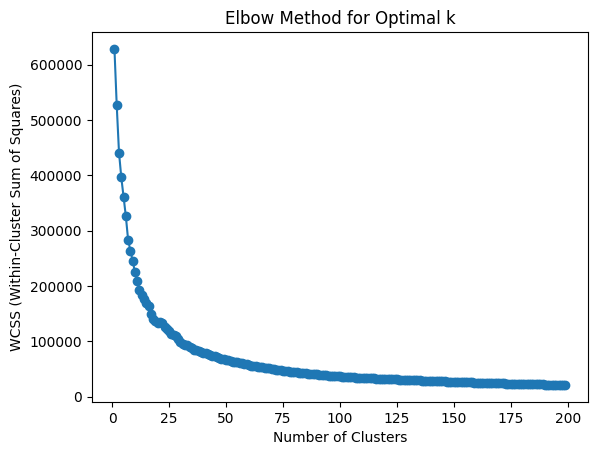

In [9]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Range of clusters to evaluate
cluster_range = range(1, 200)

# Store WCSS (within-cluster sum of squares)
wcss = []

# Calculate WCSS for each k
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(cluster_range, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.show()


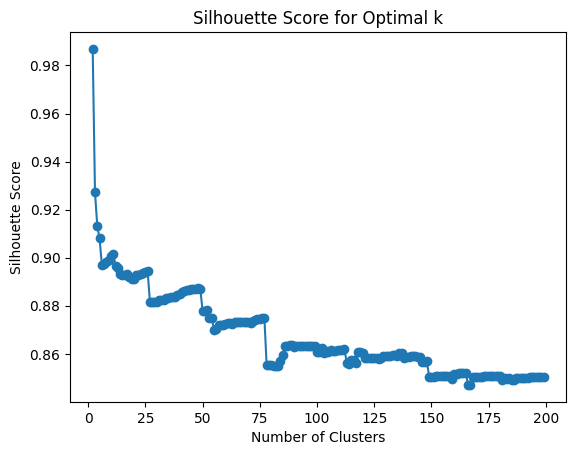

In [10]:
from sklearn.metrics import silhouette_score

# Store Silhouette Scores
sil_scores = []

# Calculate silhouette score for each k
for k in cluster_range[20:100]:  # Start from 2 clusters, as silhouette score requires at least 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    sil_scores.append(score)

# Plot the Silhouette Scores
plt.plot(cluster_range[20:100], sil_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()


In [11]:
# Apply k-means
kmeans = KMeans(n_clusters=50, random_state=42)  # Adjust `n_clusters` as needed
labels = kmeans.fit_predict(X_scaled)

# Identify small clusters as anomalies
cluster_sizes = np.bincount(labels)
anomalous_clusters = np.where(cluster_sizes < 10)[0]  # Define a threshold for small clusters

# Pseudo-labels: +1 for normal, -1 for anomalies
pseudo_labels = np.array([1 if label not in anomalous_clusters else -1 for label in labels])

print("k-means Labels:", labels)
print("Pseudo-Labels:", pseudo_labels)

# Use pseudo-labels to evaluate SGDOneClassSVM
model = SGDOneClassSVM()
model.fit(X_scaled)

# Evaluate the model
predictions = model.predict(X_scaled)
f1 = f1_score(pseudo_labels, predictions, pos_label=-1)
print("F1 Score:", f1)


k-means Labels: [17 17  0 ...  0 17 17]
Pseudo-Labels: [1 1 1 ... 1 1 1]
F1 Score: 0.0010709709499129836
